# Cancer detection using CNNs

This notebook demonstrates how to use Convolutional Neural Networks (CNNs) for cancer detection using a dataset of histopathological images. The dataset is available on Kaggle and contains images of breast cancer tissue samples. The goal is to build a model that can detect cancer in the images and classify them as either normal or cancerous.

We are going to use PyTorch(GPU) for this task. The notebook will cover the following steps:
1. Load the dataset and preprocess the images.
2. Define the model architecture.
3. Train the model.
4. Evaluate the model.

This notebook is also the assignment for the course "Introduction to Deep Learning" from the University of Colorado Boulder on Coursera.

## Setup

In [74]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from joblib import Parallel, delayed
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from tqdm import tqdm
import cv2

from sklearn.decomposition import PCA
sns.set_theme(style="dark")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## EDA

In [13]:
train_labels = pd.read_csv("data/train_labels.csv")

In [ ]:
positive_sample = np.random.choice(os.listdir('data/train/0'), size=5, replace=False)
negative_sample = np.random.choice(os.listdir('data/train/1'), size=5, replace=False)


Our images consist of 96x96 pixels in RGB format. We are going to plot 5 random images from each class to get a sense of the data.

Pixels per image: (96, 96)
Number of channels: 3


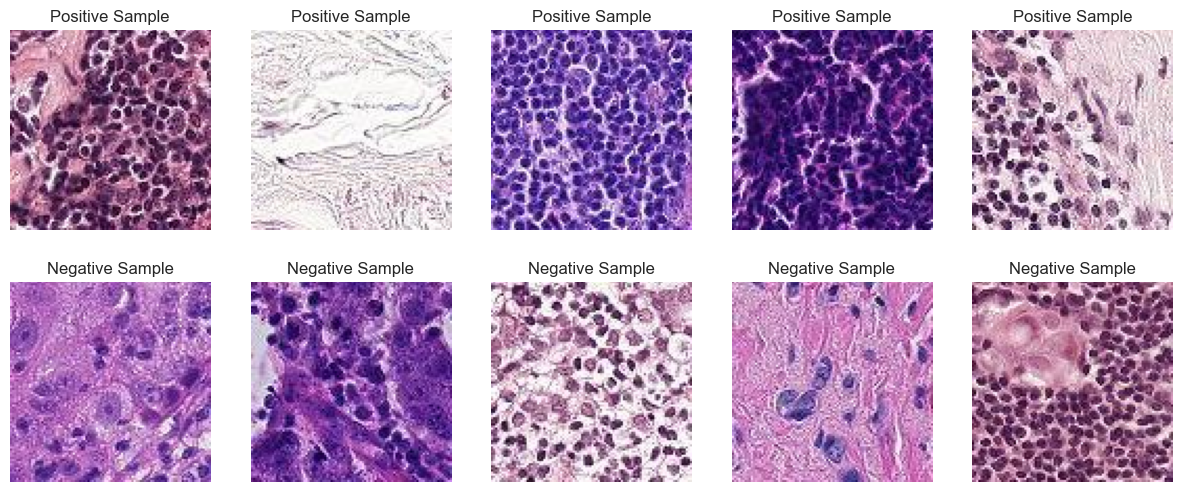

In [ ]:

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i, img_name in enumerate(positive_sample):
    img = Image.open(os.path.join('data/train/0', img_name))
    ax[0, i].imshow(img)
    ax[0, i].axis('off')
    ax[0, i].set_title('Positive Sample')

for i, img_name in enumerate(negative_sample):
    img = Image.open(os.path.join('data/train/1', img_name))
    ax[1, i].imshow(img)
    ax[1, i].axis('off')
    ax[1, i].set_title('Negative Sample')
    
print('Pixels per image:', img.size)
print('Number of channels:', len(img.getbands()))

We are going to split the dataset into training and validation sets. The dataset is already split into two folders: `train` and `val`. Each folder contains subfolders for normal and cancerous images.

We have 176020 training images and 44005 validation images. The dataset is imbalanced, with more normal images than cancerous images. We will use data augmentation to balance the dataset during training.

In [11]:
training_set = ImageFolder(root='data/train', transform=None)
print(f"Number of training samples: {len(training_set)}")
train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validation_set = ImageFolder(root='data/val', transform=None)
print(f"Number of validation samples: {len(validation_set)}")
val_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

Number of training samples: 176020
Number of validation samples: 44005


In [28]:
training_set_labels = pd.DataFrame({
    'id': [os.path.basename(path).split('.')[0] for path, _ in training_set.samples],
    'label': [label for _, label in training_set.samples]
})

As we can see the dataset is imbalanced, having more normal images than cancerous images. We will use data augmentation to balance the dataset during training or we can use weighted loss function to handle the imbalance.

Text(0, 0.5, '')

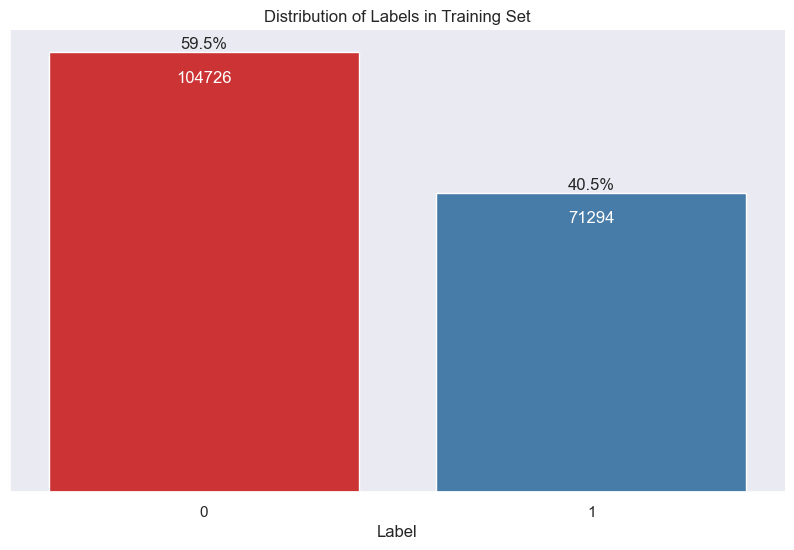

In [44]:
plt.figure(figsize=(10, 6))

bars = sns.countplot(x='label', data=training_set_labels, hue='label', palette='Set1', legend=False)

sns.despine()
percentages = training_set_labels['label'].value_counts(normalize=True) * 100
for bar, percentage in zip(bars.patches, percentages):
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')
    bars.text(bar.get_x() + bar.get_width() / 2, height - 8000, f'{int(height)}', ha='center', va='bottom', color='white')

plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=True) 
plt.xlabel('Label')
plt.title('Distribution of Labels in Training Set')
plt.ylabel('') 


Let's use some dimensionality reduction techniques to visualize the data. We will use PCA to reduce the dimensionality of the images and plot them in a 2D space.

In [87]:


IMG_SIZE = 96
batch_size = 4000
max_samples = 20000

def process_batch(df_batch):
    vectors = []
    labels = []
    for row in df_batch.itertuples():
        img_path = os.path.join('data/train', str(row.label), f"{row.id}.jpg")
        img_cv = cv2.imread(img_path)
        if img_cv is None:
            continue
        img_cv = cv2.resize(img_cv, (IMG_SIZE, IMG_SIZE))
        img_flat = (img_cv.flatten() / 255.0).astype(np.float32)
        vectors.append(img_flat)
        labels.append(row.label)  # store label
    return vectors, labels

# Split dataset into positive and negative classes
df_pos = training_set_labels[training_set_labels.label == 1]
df_neg = training_set_labels[training_set_labels.label == 0]

# Shuffle
df_pos = df_pos.sample(frac=1, random_state=42).reset_index(drop=True)
df_neg = df_neg.sample(frac=1, random_state=42).reset_index(drop=True)

all_vectors = []
all_labels = []
i = 0

with tqdm(total=max_samples, desc="Sampling from both classes") as pbar:
    while len(all_vectors) < max_samples:
        pos_batch = df_pos.iloc[i:i + batch_size // 2]
        neg_batch = df_neg.iloc[i:i + batch_size // 2]

        pos_vectors, pos_labels = process_batch(pos_batch)
        neg_vectors, neg_labels = process_batch(neg_batch)

        all_vectors.extend(pos_vectors)
        all_labels.extend(pos_labels)
        all_vectors.extend(neg_vectors)
        all_labels.extend(neg_labels)
        pbar.update(len(pos_vectors) + len(neg_vectors))

        if i + batch_size // 2 >= min(len(df_pos), len(df_neg)):
            break

        i += batch_size // 2

# Truncate to exactly max_samples if needed
X = np.stack(all_vectors[:max_samples]).astype(np.float32)
y = np.array(all_labels[:max_samples]).astype(np.int32)


Sampling from both classes: 100%|██████████| 20000/20000 [03:37<00:00, 91.88it/s]


Explained variance by PC1 and PC2: [0.35256043 0.0183598 ]


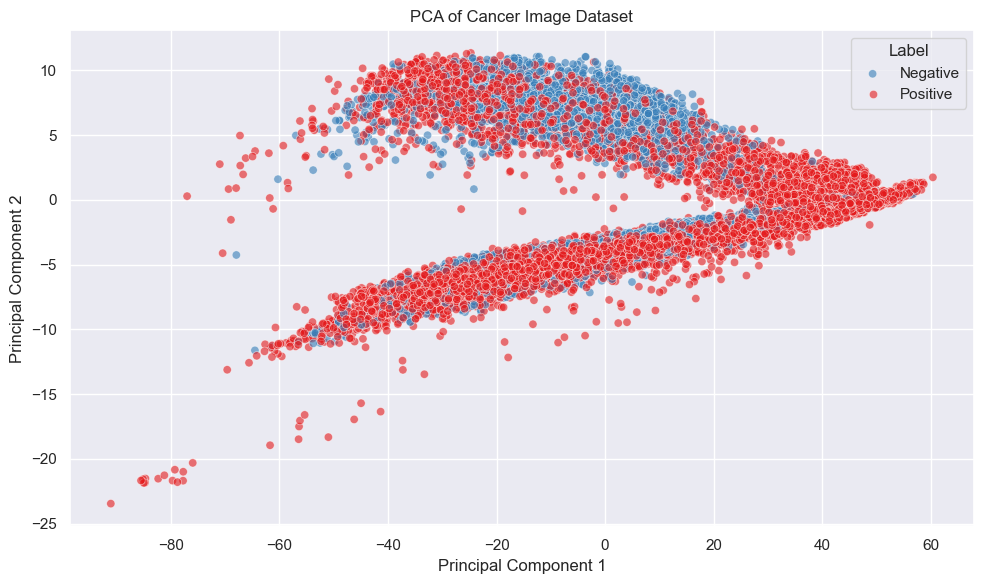

In [88]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"Explained variance by PC1 and PC2: {pca.explained_variance_ratio_}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title("PCA of Cancer Image Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Label", labels=["Negative", "Positive"])
plt.tight_layout()
plt.show()